# Synchronised backpropagaton

This notebook uses a previously fitted geometry to apply backpropagation to a glide. 

Notice that with the recordings of 12/04/2019, the results are not good because the impedance calculated at the reference plane is far from that of a straight pipe. This usually works well, and is not dependent on the backpropagation routine.

Hints:
* check that the microphones are working in a linear regime (apply a sinusoidal excitation, or a chirp, check that non-linearities are the same in both microphones
* Redo the calibration (this shouldn't be the problem because a measurement of the impedance of a 18cm tube was ok)
* check that the microphone holes did not get clogged with water

## Requires:

* PyPeVoc: https://github.com/goiosunsw/PyPeVoc
* audacity.py: https://github.com/goiosunsw/audacity.py


In [1]:
import os
import numpy as np
import matplotlib.pyplot as pl
import pandas
%matplotlib inline
from scipy.io.matlab import loadmat
from scipy.signal import argrelmax
from scipy.linalg import pinv, lstsq

# for reading audacity projects
import audacity
# for calculations of impedance from geometry
import pympedance.Synthesiser as psyn
# for reading UNSW impedance calibrations
import pympedance.UNSW as pun

from pypevoc import PV
# for chunk segmentation
import pypevoc.speech.SpeechChunker as schunk


# function to plot imaginary transfer functions
from pympedance.plot_utils import bodeplot


Function to convert from geometry parameters to optimiser parameters. Needed because the optimiser requires a function that takes a list of arguments (and not a dict, or a complicated object such as the duct construction functions)

In [2]:
def argdict_to_duct(**kwargs):
    loss_mult = kwargs['loss_mult']
    is_rigid = True
    try:
        compl = kwargs['compliance']
        is_rigid = False
    except KeyError:
        compl = None
    try:
        inert = kwargs['inertance']
        is_rigid = False
    except KeyError:
        inert = None
    try:
        resist = kwargs['resistance']
        is_rigid = False
    except KeyError:
        resist = None
    
    duct = psyn.Duct()
    
    ii=0
    while True:
        duct_dict = {}
        try:
            duct_dict['length'] = kwargs['length_%d'%ii]
            duct_dict['radius'] = kwargs['radius_%d'%ii]
            radius=duct_dict['radius']
            duct_dict['loss_multiplier'] = loss_mult
        except KeyError:
            break
        if is_rigid:
            duct.append_element(psyn.StraightDuct(**duct_dict))
        else:
            duct_dict['compliance'] = compl
            duct_dict['inertance'] = inert
            duct_dict['resistance'] = resist
            duct.append_element(psyn.StraightDuctWithParallel(**duct_dict))
        ii+=1
            

    term = kwargs['term']
    if term == 'open':
        duct.set_termination(psyn.FlangedPiston(radius=radius))
    elif term == 'closed':
        duct.set_termination(psyn.PerfectClosedEnd())
    return duct

def func_cf(x, **kwargs):
    duct = argdict_to_duct(**kwargs)
    return duct.get_input_impedance_at_freq(x)

def logf_cf(x,**kwargs):
    z = func_cf(x,**kwargs)
    return 20*np.log10(np.abs(z))

Change the next line for the appropraite file locations

In [3]:
datadir = '/media/goios/ANDREDATA2/Data/20190412 - newChannels'

# This file will be used to generate a first estimation of the vocal tract geometry
initial_vt_impedance_measurement_file = os.path.join(datadir,'meas/aa_@_glotclose.mat')

# glide recording
glide_audacity_file = os.path.join(datadir, '2858mm_aa.aup')

# channels id
mic_channel_numbers = [0,1]
egg_channel_number = 2

# 1. Read an impedance measurement without phonation

In [4]:
#imp0 = pun.ImpedanceMeasurement(initial_vt_impedance_measurement_file)
imp_params = pun.MeasurementParameters(os.path.join(datadir,'calib/LiveParameters.mat'))

# Read a tract geometry



<Figure size 432x288 with 0 Axes>

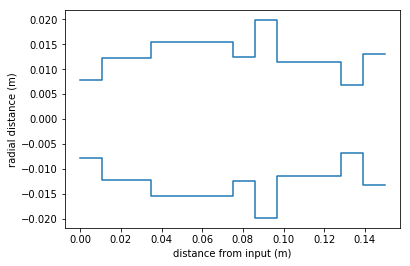

In [5]:
pl.figure()

geom_dict = pandas.read_csv(os.path.join(datadir,'aa_@_glotclose_geometry_fit.csv'),header=None,index_col=0).to_dict()[1]

geom0 = {}
for k,v in geom_dict.items():
    try:
        geom0[k]=float(v)
    except ValueError:
        geom0[k]=v

geom0['term']='closed'

vt = argdict_to_duct(**geom0)
vt.plot_geometry()



# Load a glide

In [6]:
aud = audacity.Aup(glide_audacity_file)
sr=aud.rate
for reg in aud.get_annotation_data():
    print (reg)
#select a trial number
rno=2

{'start': 1.9184315608, 'end': 12.7324475612, 'label': 'up1'}
{'start': 13.794436461, 'end': 21.274035701, 'label': 'up2'}
{'start': 22.1076398911, 'end': 31.6997976951, 'label': 'up3'}
{'start': 32.1565671143, 'end': 42.9363254083, 'label': 'up4'}
{'start': 43.5758025952, 'end': 51.7062982577, 'label': 'up5'}
{'start': 53.6818259959, 'end': 62.280510313, 'label': 'up6'}
{'start': 67.384908573, 'end': 78.0162168057, 'label': 'down1'}
{'start': 78.7927248184, 'end': 89.846544764, 'label': 'down2'}
{'start': 91.8563302086, 'end': 103.2298887476, 'label': 'down3'}
{'start': 104.0520737022, 'end': 115.2886014155, 'label': 'down4'}
{'start': 116.156463312, 'end': 126.5708060706, 'label': 'down5'}
{'start': 127.6213757349, 'end': 137.2592104808, 'label': 'down6'}
{'start': 144.5218442467, 'end': 147.2167838202, 'label': 'fast_up'}
{'start': 147.7649071232, 'end': 153.0177554445, 'label': 'fast down'}
{'start': 153.5202018056, 'end': 159.9606506169, 'label': 'fast_down_up'}


# Load a glide recording

In [7]:
label='up4'
for reg in aud.get_annotation_data():
    if reg['label'].find(label)>-1:
        break
print(reg)

{'start': 32.1565671143, 'end': 42.9363254083, 'label': 'up4'}


# Harmonic extraction from glide signal

**PV** decomposes the signal into a sum of $N$ partial sinusoidal components at regular frames

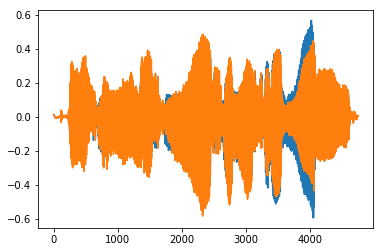

In [8]:

ww = []
for chno in mic_channel_numbers:
    ww.append(aud.get_channel_data(chno,t_start=reg['start'],t_end=reg['end']))
    
ww = np.array(ww).T
pl.figure()
pl.plot(ww[::100,:])
#pl.xlim(400,410)

In [9]:
ww.shape

(475387, 2)

/home/goios/Envs/unsw/lib/python3.6/site-packages/pypevoc-0.1-py3.6.egg/pypevoc/PVAnalysis.py:168: RuntimeWarning: divide by zero encountered in true_divide
  frat = fx / self.oldfft
/home/goios/Envs/unsw/lib/python3.6/site-packages/pypevoc-0.1-py3.6.egg/pypevoc/PVAnalysis.py:168: RuntimeWarning: invalid value encountered in true_divide
  frat = fx / self.oldfft
/home/goios/Envs/unsw/lib/python3.6/site-packages/pypevoc-0.1-py3.6.egg/pypevoc/PVAnalysis.py:330: RuntimeWarning: divide by zero encountered in log10
  mag = 20*np.log10(self.mag)


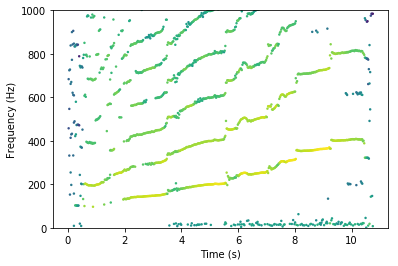

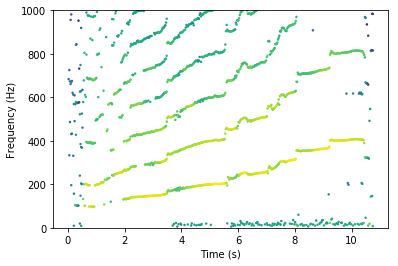

In [10]:
pva = []
mic_channels = [0,1]
for ii in mic_channels:
    wwi = ww[:,ii]
    pv = PV(wwi,sr,nfft=2**11,hop=2**10,pkthresh=1e-7)
    pv.run_pv()
    pva.append(pv)
    pv.plot_time_freq()
    pl.ylim(0,1000)

## Determine glide fundamental frequency

This is best done using the EGG signal. 

`hop` should be the same as th decomposition above so that frequency vector matches the partial amplitudes and frequencies

/home/goios/Envs/unsw/lib/python3.6/site-packages/pypevoc-0.1-py3.6.egg/pypevoc/PVAnalysis.py:168: RuntimeWarning: divide by zero encountered in true_divide
  frat = fx / self.oldfft
/home/goios/Envs/unsw/lib/python3.6/site-packages/pypevoc-0.1-py3.6.egg/pypevoc/PVAnalysis.py:168: RuntimeWarning: invalid value encountered in true_divide
  frat = fx / self.oldfft


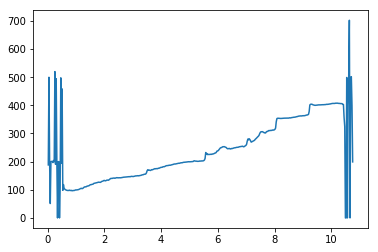

In [11]:
wegg = aud.get_channel_data(egg_channel_number,t_start=reg['start'],t_end=reg['end'])
pve = PV(wegg,sr,nfft=2**11,hop=2**10,pkthresh=1e-7)
pve.run_pv()
f0=pve.calc_f0()
t=pve.get_time_vector()
pl.figure()
pl.plot(t,f0)

## extract the calibration matrix

from the impedance measurement paramter object. This can usually be extracted from a measurement file as well, but should match the matrix in `calib/MeasurementParameters.mat`

`calibfvec` contains the frequencies corresponding to each of the matrices in `calibmx` $C(f)$

$$\left[\begin{matrix} \mu_1(f)\\ \mu_2(f)\end{matrix}\right] =  C(f) \left[\begin{matrix} p(f)\\ u(f)\end{matrix}\right]$$

where $\mu_1(f)$ and $\mu_2(f)$ are the two microphone complex amplitudes at a given frequency

In [12]:
calibmx = imp_params.A#.transpose([1,0,2])
calibfvec = imp_params.frequency_vector
calibmx.shape

(2, 2, 364)

## Calculate acoutic variables

`pvec` and `uvec` are the complex amplitudes of pressure and flow at the refence plane at the fundamental frequency.

When plotted against the corresponding frequency, they should trace the impedance of the long pipe + impedance head, as seen from the reference plane.

They are calculated by solving the linear system using the calibration matrix and the microphone complex amplitudes. Since the frequencies of the glide signal do not match the frequencies at which the impedance matrix was measured, we calculate using the matrix just above and just below, and then intrpolate the reult.

`pglot` and `uglot` are the complex amplitudes at the glottis, backpropagated from `pvec` and `uvec`. They should trace the impedance as seen from the glottis

They are obtained by multiplying the reference plane variables by the transfer matrix of the fitte vocal tract.

In [13]:
f0.shape

(463,)

In [14]:
pvec = np.zeros(f0.shape, dtype='complex')
uvec = np.zeros(f0.shape, dtype='complex')

pglot = np.zeros(f0.shape, dtype='complex')
uglot = np.zeros(f0.shape, dtype='complex')

# these were used for the backpropagation using a straight pipe
dist = 0.17
c=345.0

# Characteristic impedances 
zc_head = psyn.StraightDuct(length=0.3,radius=0.013).char_impedance
zc_glot = vt.elements[0].char_impedance

for ii in range(pva[0].f.shape[0]):
    # frequency of the glide at this frame
    fi = f0[ii]
    # calculate the complex amplitudes of microphone signals
    # from the PV analysis
    camps = []
    for mic_no in range(len(pva)):
        pv = pva[mic_no]
        idxpv = np.argmin(np.abs(pv.f[ii,:]-fi))
        camps.append(pv.mag[ii,idxpv] * np.exp(1j*pv.ph[ii,idxpv]))
    try:
        # apply the calibration matrix above and below the glide frequency
        calibidxl = np.flatnonzero(calibfvec-fi < 0)[-1]
        calibidxr = np.flatnonzero(calibfvec-fi > 0)[0]
        calibidxs = [calibidxl, calibidxr]
        pulr = []
        flr = []
        for cidx in calibidxs:
            aa = np.linalg.inv(calibmx[:,:,cidx])
            pu = np.matmul(aa,camps)
            pulr.append(pu)
            flr.append(calibfvec[cidx])
        # pulr contains pressure and flow approximations at calibration frequencies 
        # above and below the glide frequency
        pulr=np.array(pulr)
        # now we interpolate the two results
        pvec[ii] = np.interp(fi,flr,pulr[:,0])
        # minus sign here is because the head has been calibrated to measure
        # flow going towards the mouth. If looking towards the long pipe
        # flow has to be reversed
        uvec[ii] = -np.interp(fi,flr,pulr[:,1])/zc_head
        
        ## backpropagation
        k = 2*np.pi*fi/c
        kl = -k*dist
        # next line for a straight duct packpropagation
        #backpropmx = np.array([[np.cos(kl), -1j*np.sin(kl)],[-1j*np.sin(kl), np.cos(kl)]])
        
        # get the transfer matrix at the glide frequency
        backpropmx = vt.transfer_mx_at_freq(fi).squeeze()
        # invert and multiply to get variables at glottis
        backpropmx = np.linalg.inv(backpropmx)
        pug = np.matmul(backpropmx,np.array([pvec[ii],uvec[ii]]))
        pglot[ii] = pug[0]
        uglot[ii] = pug[1]*zc_glot
    except IndexError:
        pass

## Impedance plots 

Top graph should trace the impedance of the long pipe

This usually works well, I don't know why it's not working here... Check the other two notebooks.

/home/goios/Envs/unsw/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/goios/Envs/unsw/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


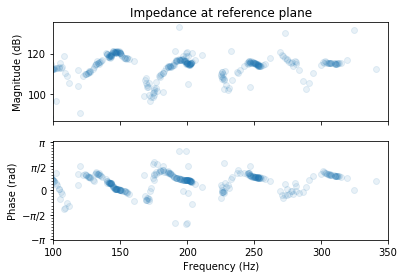

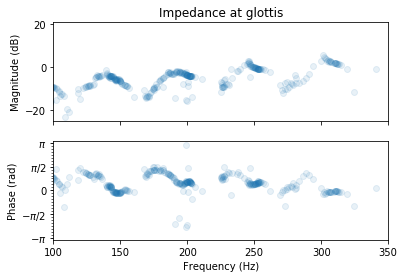

In [15]:
fig,ax=bodeplot(f0,pvec/uvec,marker='o',lw=0,alpha=.1)
pl.xlim(100,350)
ax[0].set_title('Impedance at reference plane');
#pl.tight_layout()
fig,ax=bodeplot(f0,pglot/uglot,marker='o',lw=0,alpha=.1)
pl.xlim(100,350)
ax[0].set_title('Impedance at glottis');
#pl.tight_layout()

## Inter-mic transfer functions

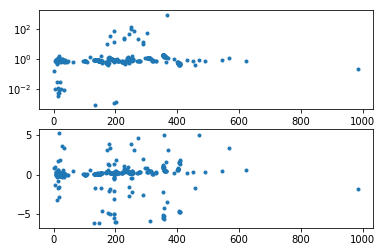

In [16]:
fig,ax=pl.subplots(2)
ax[0].semilogy(pva[0].f[:,0],pva[0].mag[:,0]/pva[1].mag[:,0],'.')
ax[1].plot(pva[0].f[:,0],pva[0].ph[:,0]-pva[1].ph[:,0],'.')